# Core 7.7 Feature Store - Aggregations

In this section, we will take a look at the built in aggregation features for batch and real-time data.

---

### References

Much of the following content is derived from the official documenation:
- [Feature set transformations](https://docs.mlrun.org/en/stable/feature-store/transformations.html)
- [FeatureSet.add_aggregation](https://docs.mlrun.org/en/stable/api/mlrun.feature_store.html#mlrun.feature_store.FeatureSet.add_aggregation)

---

### What is an aggregation?

So what exactly is an `aggregation` in the context of the feature store? It is simple syntax that allows for the creation of a new column in a `Feature Set` by performing time-based aggregations on an existing column.

The aggregation itself is calculated based on the `Entity` of the record. For example, multiple records with the same `stock_ticker` will be used when computing an `aggregation`.

---

### What aggregations are supported?

At this time, the following aggregations are supported:
- count
- sum
- sqr (sum of squares)
- max
- min
- first
- last
- avg
- stdvar
- stddev

---

### What engines support aggregations?

At this time, the `storey`, and `spark` engines support aggregations. The underlying implementation is different per engine, but the syntax is the same.

---

### Adding an Aggregation

Adding an `aggregation` in the Feature Store is done at the `Feature Set` level. Much like a transformation, it is a step in the computation graph. An example of an aggregation looks like the following:

```python
import mlrun.feature_store as fstore

my_feature_set = fstore.FeatureSet(
    name="stocks",
    entities=[fstore.Entity("ticker")],
    description="Stock data per ticker",
    timestamp_key="time"
)

my_feature_set.add_aggregation(column="bid", operations=["min", "max"], windows=["1h", "1d"], period="10m")
```

Note that you can add multiple `aggregation` operations for a single column in the same step. You can also specify an optional period to perform a sliding window aggregation. The `Feature Set` will automatically detect the timestamp column, but you can also manually specify it.

---

### Example Overview

In this example, we will ingest a dataset as a `Feature Set` and add an `aggregation` to the computation graph. We will be using the `storey` engine, but the same syntax applies to the other engines as well.

---

### Setup

In [3]:
import pandas as pd
import mlrun
import mlrun.feature_store as fstore
from mlrun.datastore.sources import DataFrameSource, CSVSource

project = mlrun.get_or_create_project("iguazio-academy", context="./")

> 2022-04-28 23:33:44,891 [info] loaded project iguazio-academy from MLRun DB


### Stock Quote Aggregations via Storey Engine

In [4]:
quotes = pd.read_csv("data/stock_quotes.csv")
quotes

,ticker,time,bid,ask
0,GOOG,2016-05-25 13:30:00.023,720.50,720.93
1,MSFT,2016-05-25 13:30:00.023,51.95,51.96
2,MSFT,2016-05-25 13:30:00.030,51.97,51.98
3,MSFT,2016-05-25 13:30:00.041,51.99,52.00
4,GOOG,2016-05-25 13:30:00.048,720.50,720.93
5,AAPL,2016-05-25 13:30:00.049,97.99,98.01
6,GOOG,2016-05-25 13:30:00.072,720.50,720.88
7,MSFT,2016-05-25 13:30:00.075,52.01,52.03


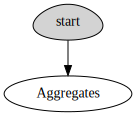

In [7]:
quote_set = fstore.FeatureSet(
    name="stock-quotes-aggregated",
    entities=[fstore.Entity("ticker")],
    description="Stock quotes with aggregations",
)

quote_set.add_aggregation(column="bid", operations=["avg", "sum", "count"], windows=["1h"])

quote_set.plot()

In [8]:
fstore.ingest(featureset=quote_set, source=DataFrameSource(df=quotes))

,bid_sum_1h,bid_count_1h,bid_avg_1h,time,bid,ask
ticker,,,,,,
GOOG,720.50,1.0,720.50,2016-05-25 13:30:00.023,720.50,720.93
MSFT,51.95,1.0,51.95,2016-05-25 13:30:00.023,51.95,51.96
MSFT,103.92,2.0,51.96,2016-05-25 13:30:00.030,51.97,51.98
MSFT,155.91,3.0,51.97,2016-05-25 13:30:00.041,51.99,52.00
GOOG,1441.00,2.0,720.50,2016-05-25 13:30:00.048,720.50,720.93
AAPL,97.99,1.0,97.99,2016-05-25 13:30:00.049,97.99,98.01
GOOG,2161.50,3.0,720.50,2016-05-25 13:30:00.072,720.50,720.88
MSFT,207.92,4.0,51.98,2016-05-25 13:30:00.075,52.01,52.03


### Stock Trade Aggregations via Spark Engine

In [9]:
trades = pd.read_csv("data/stock_trades.csv")
trades

,ticker,time,price,quantity
0,MSFT,2016-05-25 13:30:00.023,51.95,75
1,MSFT,2016-05-25 13:30:00.038,51.95,155
2,GOOG,2016-05-25 13:30:00.048,720.77,100
3,GOOG,2016-05-25 13:30:00.048,720.92,100
4,AAPL,2016-05-25 13:30:00.048,98.00,100


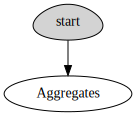

In [25]:
trade_set = fstore.FeatureSet(
    name="stock-trades-aggregated",
    entities=[fstore.Entity("ticker")],
    description="Stock trades with aggregations",
    timestamp_key="time",
    engine="spark"
)

trade_set.add_aggregation(column="price", operations=["max", "avg"], windows=["1m"], period="1m")

trade_set.plot()

In [26]:
import pandas as pd
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [27]:
spark = SparkSession.builder.appName("Spark function").getOrCreate()

In [28]:
v3io_data_path = "v3io://users/nick/igz_repos/iguazio-academy/modules/core/7_feature_store/data/stock_trades.csv"

In [29]:
fstore.ingest(featureset=trade_set, source=CSVSource(path=v3io_data_path), spark_context=spark)

> 2022-04-28 23:37:05,225 [info] writing to target parquet, spark options {'path': 'v3io://projects/iguazio-academy/FeatureStore/stock-trades-aggregated/parquet/sets/stock-trades-aggregated-latest', 'format': 'parquet'}
> 2022-04-28 23:37:07,074 [info] writing to target nosql, spark options {'path': 'v3io://projects/iguazio-academy/FeatureStore/stock-trades-aggregated/nosql/sets/stock-trades-aggregated-latest', 'format': 'io.iguaz.v3io.spark.sql.kv', 'key': 'ticker'}


DataFrame[ticker: string, time: timestamp, price_max_1m: double, price_avg_1m: double, time_window: string]

---